<h1>tree_detector</h1>

The purpose of this script is to test whether `trackpy` can be used to locate trees with yellow flowers.

See `trackpy` tutorial for more examples of what the package can do: http://soft-matter.github.io/trackpy/dev/tutorial/walkthrough.html

In [102]:
## Import libraries

## --> Working with images
import numpy as np
import skimage.io as skimage

## --> Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

## --> Particle detection
import trackpy as tp

## --> Timing for performance
from time import time,sleep

<h3>Read in images</h3>

First we read in the images from the first class on segmentation.

The file `20160816_141229_0c60_visual.tif` was the smallest, so that's where I started.

To further reduce the size of the image, I cropped it down to a 2000 x 2000 window over the four channels

In [3]:
## Load image
path = "/Users/aspierer/Documents/Postdoc/classes/SpatialData/segmentation/visual/"
img = skimage.imread(path+"20160816_141229_0c60_visual.tif")
print("Image dimensions (w x h x channel):",img.shape)

## Crop image
img = img[2000:4000,3000:5000,:]

Image dimensions (w x h x channel): (5472, 6904, 4)


<h3>Spot checking cropped image</h3>

Next, I plotted out the four channels (red, green, blue, infrared; not the right order) to figure out which channel would give the best contrast between the forst background and the focal (yellow) trees. 

We can see channel 1 gives the bet contrast, while channel 4 (IR band) is not very helpful. Plotting out the three (useful) channels in one image, we can spot check that there are yellow trees in the frame and their relative position.

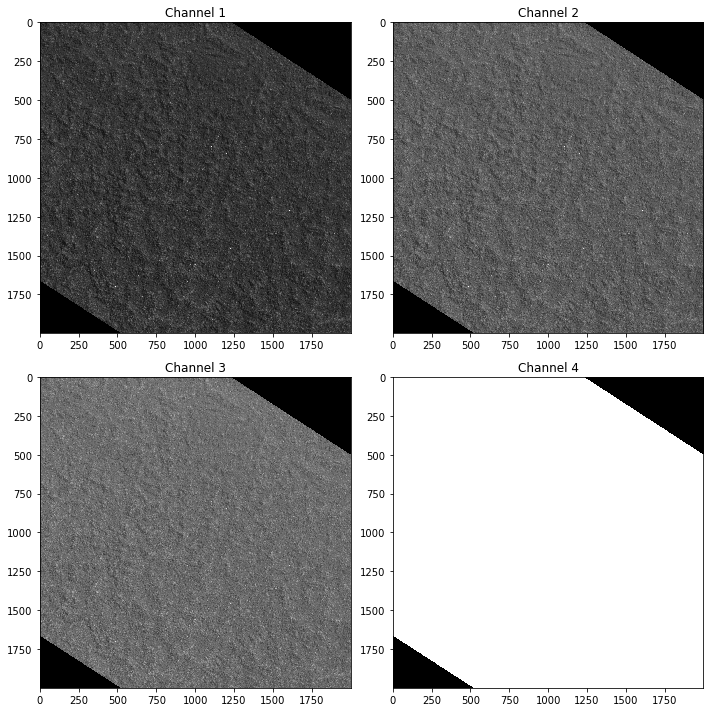

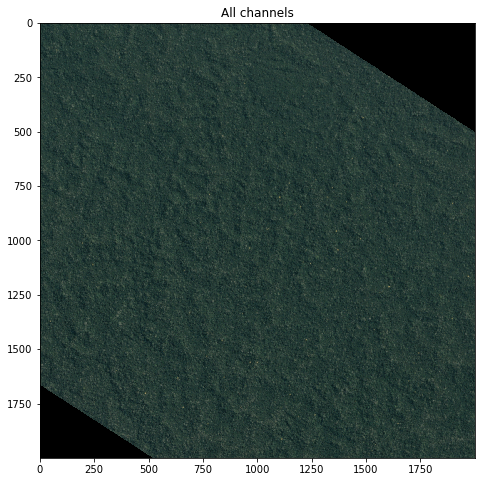

In [17]:
## Create subplots of the different channels
plt.figure(figsize=(10,10))
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.title("Channel " + str(i+1))
    plt.imshow(img[:,:,i],cmap=cm.gray)
plt.tight_layout()

## Create a plot with all channels
plt.figure(figsize=(8,8))
plt.title("All channels")
plt.imshow(img[:,:,:3])

<h3>Highlight a focal area</h3>

Since there is a lot of space in the image and we are just checking to make sure `trackpy` works with out setup, we can focus on a region we suspect has trees. This region is highlighted in cyan and should contain some trees we care about

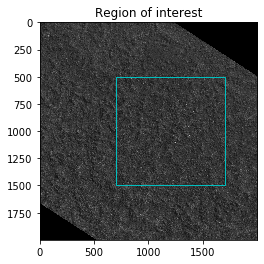

In [42]:
## Specify rectangle dimensions
x = 700
y = 500
h = 1000
w = 1000

## Plot image in grayscale for only channel 0
fig,ax = plt.subplots(1)
ax.imshow(img[:,:,0],cmap=cm.gray)
ax.set_title("Region of interest")

## Add rectangle
rect = mpatches.Rectangle((x,y),w,h,linewidth=1,edgecolor='c',facecolor='none')
ax.add_patch(rect)

<h3>Testing trackpy on images of trees in a forest</h3>

`trackpy` is great for particle detection and has the flexibility to incorporate several spot parameters: `diameter`,`minmass`,`maxsize`, (signal) `threshold`, `eccentricity` (roundness).

We can call the `trackpy.locate` function to get the algorithm to find the centroids of pixel clusters that match the specified parameters. It outputs a DataFrame with the x,y coordinates, as well as metrics about the spots themselves.

Spot locations are visualized using the `trackpy.annotate` function. Sometimes we need to refine the search parameters a bit more, so to facilitate the tedious, trial-and-error part of this exercise, we create a function `output_stats` to create histograms to do that for us. For this, I spent a few minutes figuring out the \~approximate\~ parameters to save folks the effort of figuring it out themselves.

\*NOTE: Because we specify trackpy to be abbreviated as tp early on, we have the abbreviation instead of the full library name when we call it

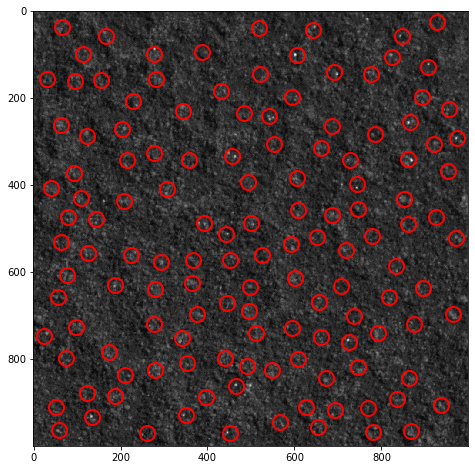

,y,x,mass,size,ecc,signal,raw_mass,ep
0,25.584152,927.043932,6945.835530,17.477109,0.337408,31.118086,73682.0,NaN
1,42.475865,641.502839,10468.681568,15.245698,0.513965,63.629520,76916.0,NaN
2,35.654639,64.447965,10773.360145,14.631933,0.165974,32.975882,77921.0,NaN
3,56.497055,167.592779,9621.526503,16.148987,0.524895,37.155924,77965.0,NaN
4,38.611454,518.862023,8361.476232,15.033845,0.165927,31.118086,78557.0,NaN


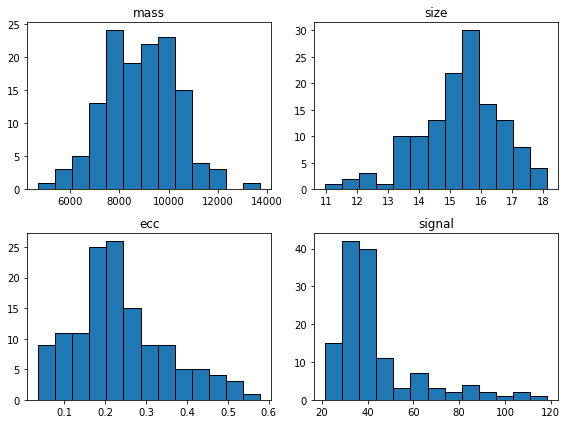

In [87]:
## Define a function to output spot metrics
def output_stats(df):
    '''Takes the trackpy DataFrame output and plots out the spot metrics for all TRUE spots'''
    for i,col in enumerate(['mass','size','ecc','signal'],start=1):
        plt.subplot(2,2,i)
        plt.title(col)
        x = df[col]
        bins = len(x)//10
        plt.hist(x,bins=bins, histtype='bar', ec='black')
    plt.tight_layout()
    return

## Create a temp image usig the dimensions defined above.
temp_img = img[x:x+w,y:y+h,0]

## Specify detector parameters
diameter = 51 # must be odd
maxsize = 150
minmass = 1
threshold = 1

## Create a trackpy object using some parameters selected from trial and error
f = tp.locate(temp_img,
              diameter = diameter,
              maxsize = maxsize,
              minmass = minmass,
              threshold = threshold,
              invert = False) # Invert is important because white dots on black background

## Visualize spot locations
plt.figure(figsize=(8,8))
tp.annotate(f,temp_img)

## Visualize spot metrics
plt.figure(figsize=(8,6))
output_stats(f)

## See output DataFrame
f.head()

<h3>Selecting a threshold</h3>

Looking at the spot locations, we see that we capture most TRUE spots (suspected yellow trees), but also a whole bunch of other FALSE spots (suspected artefacts). This is good because it tells us that the `diameter` and `maxsize` parameters are on the right track.

Next, we can turn to the `mass` and (signal) `threshold` parameters. The `mass` threshold was already preset at around 500 and doesn't change the results much if we set it to 1...so in this example, `mass` is not a limiting factor in locating the major features we care about.

Instead, the histogram points to `threshold` as a potentially good parameter to target. There is a large spike when `threhold` < 40 and a tail when it is > 40. So we can approximate that \~40 is a sufficient threshold.

And in fact, this value does a decent job of dropping the weaker hits and leaving the stronger ones! There are one or two putative trees I might have said were yellow trees but weren't picked up. Interestingly, there were a few TRUE spots detected that I would say have a two (or three) trees in a given cluster. These could probably be resolved with optimization of the detection parameters but for this example we can be content.

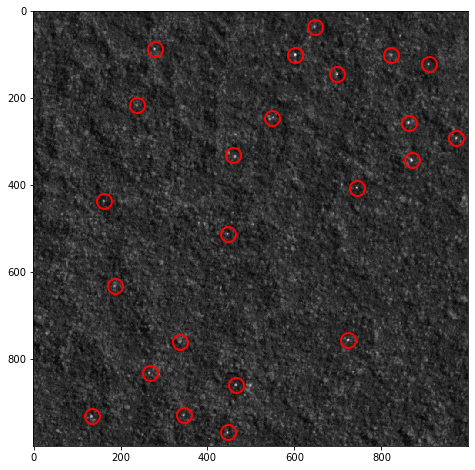

,y,x,mass,size,ecc,signal,raw_mass,ep
0,35.529116,646.800703,925.182506,1.743174,0.093748,63.629520,73316.0,5.341883
1,86.466996,278.999647,1315.784156,1.869932,0.056026,81.278584,81656.0,0.588983
2,99.815618,602.197242,2997.554163,2.292555,0.012347,118.434508,78293.0,0.918532
3,99.986891,822.670627,1133.720129,1.914605,0.200910,58.985029,74632.0,2.349792
4,121.725562,908.540615,1012.034478,1.706156,0.032998,71.060705,66156.0,-0.901140
5,144.118625,698.293561,2012.457730,2.214444,0.043830,85.923074,72702.0,13.160514
6,215.925820,237.626961,651.157567,1.467431,0.177290,59.449478,72250.0,-169.872150
7,246.150780,547.335529,1339.935507,4.620915,0.886467,63.165071,74157.0,2.945231
8,256.330258,862.559498,1963.226131,2.123243,0.066791,96.140953,82802.0,0.524819
9,291.703637,972.382254,1800.668964,2.039398,0.154839,93.818708,76910.0,1.193049


In [89]:
## Re-specify threshold
threshold = 40

## Create a trackpy object using some parameters selected from trial and error
f = tp.locate(temp_img,
              diameter = diameter,
              maxsize = maxsize,
              minmass=minmass,
              threshold=threshold,
              invert=False)

## Visualize spot locations
plt.figure(figsize=(8,8))
tp.annotate(f,temp_img)

## View the whole DataFrame
f

<h3>Applying this to a larger picture</h3>

It looks like we have decent results for our sub-image, now we can turn out parameters onto the original cropped picture (2000 pixels^2).

It looks like we have one errant point on the upper right diagonal (questionable in the color photo), but since there are no other spots on the diagonals, it may in fact be a tree very close to the edge (clearer in the grayscale photo). 

From a zoomed-out view, it looks like most of the main yellow trees are in fact located. So next we will try it out on the original size photo

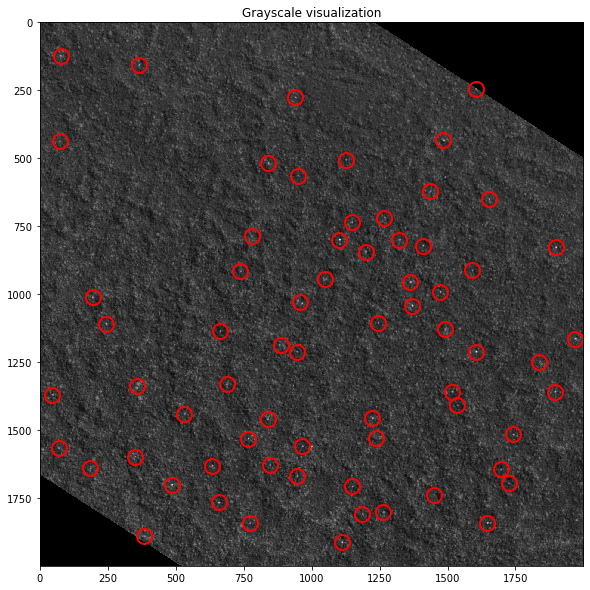

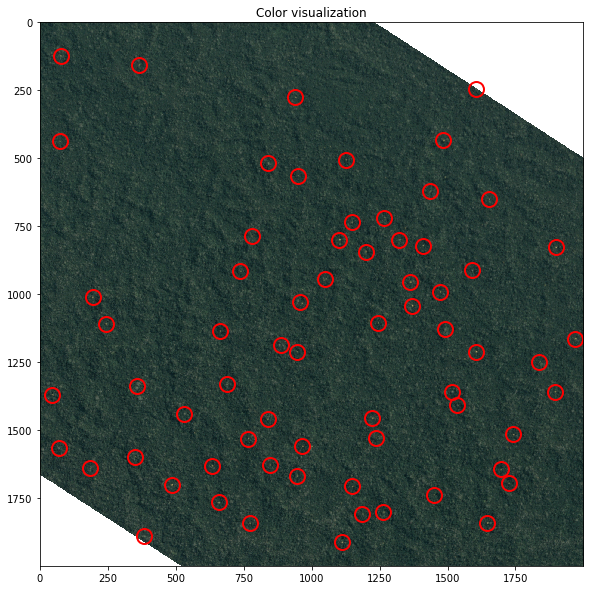

In [101]:
## Create a trackpy object using some parameters selected from trial and error
f = tp.locate(img[:,:,0],
              diameter = diameter,
              maxsize = maxsize,
              minmass=minmass,
              threshold=threshold,
              invert=False)

## Visualize the spots with the color image
plt.figure(figsize=(10,10))
plt.title('Color visualization')
tp.annotate(f,img)

## Visualize the spots with the grayscale image
plt.figure(figsize=(10,10))
plt.title('Grayscale visualization')
tp.annotate(f,img[:,:,0])

<h3>Testing parameters on the original image</h3>

I timed my computer processing the original image (dimensions = 5472 x 6904) and found it took 1.3 seconds to read in the image (\_\_ mb) and 100 seconds to process the full image.

Reading and slicing the image
--- 0.87 seconds ---
Locating trees in the image
--- 100.02 seconds ---


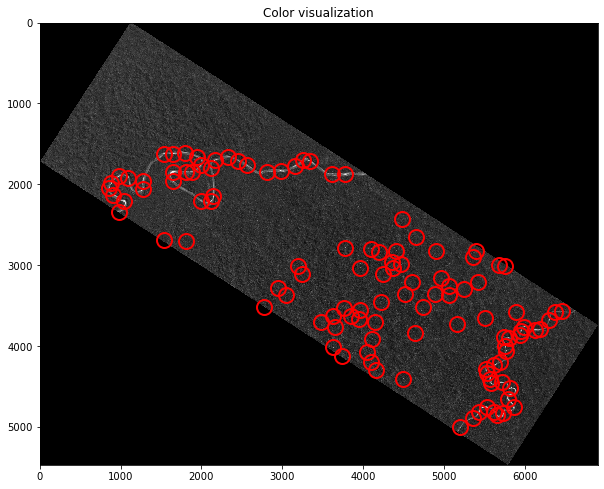

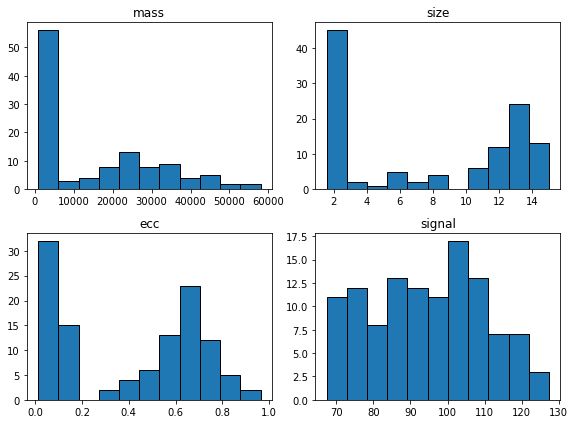

In [117]:
## Read in image
print("Reading and slicing the image")
start_time = time()
img = skimage.imread(path+"20160816_141229_0c60_visual.tif")
img = img[:,:,0]
print("--- %s seconds ---" % round((time() - start_time),2))

## Timing the function on the whole image
print("Locating trees in the image")
start_time = time()
f = tp.locate(img,
              diameter = diameter,
              maxsize = maxsize,
              minmass=minmass,
              threshold=threshold,
              invert=False)
print("--- %s seconds ---" % round((time() - start_time),2))

## Visualize the spots with the color image
plt.figure(figsize=(10,10))
plt.title('Color visualization')
tp.annotate(f,img)

## Visualize the spot metrics
plt.figure(figsize=(8,6))
output_stats(f)

<h3>Future directions</h3>

Unfortunately, the algorithm picked up the rivers at the top and bottom of the image (bad). The spot parameters for the spots picked up along the river could probably be filtered out, using the `output_stats` function to get a sense of which parameters are good for trees/filter against those greater. 

There are also some the trees between the top river and the majority of trees located between the rivers were not located. If the detector picks up the vast majority of TRUE trees, then this may be acceptable. But since we are optimizing against rivers still, we might be able to include these in our analysis.